In [1]:
import pandas as pd
import numpy as np
import arrow
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.tree import DecisionTreeRegressor

In [2]:
id = 26
df = pd.read_csv('USvideos.csv')
df_24 = df[df['category_id'] == id]

index = int(len(df_24)*0.8)
df_train =df_24[:index]
df_test = df_24[index:]

X_train = df_train[["likes"]].to_numpy()
Y_train = df_train["views"].to_numpy()
X_test = df_test[["likes"]].to_numpy()
Y_test = df_test["views"].to_numpy()

In [3]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [4]:
Y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("MSE: %.2f" % mse)
print("R2 Score: %.2f" % r2)



MSE: 3510754669665.81
R2 Score: 0.24


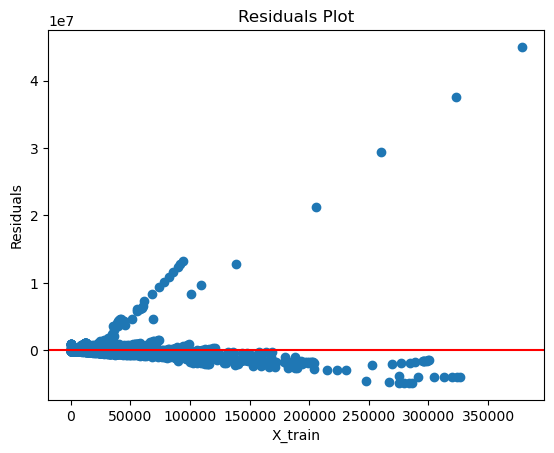

In [5]:
Y_train_pred = model.predict(X_train)

residuals = Y_train - Y_train_pred
studentized_residuals = residuals / np.sqrt(mean_squared_error(Y_train, Y_train_pred))
outliers = np.abs(studentized_residuals) > 2
plt.scatter(X_train, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('X_train')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [6]:
cook_distance = (residuals ** 2) / (model.coef_ ** 2 * X_train.var())
outliers_cooks = cook_distance > 4 / len(X_train[0])

print("Outliers based on studentized residuals:", np.where(outliers)[0])
print("Outliers based on Cook's distance:", np.where(outliers_cooks)[0])

outliers_indices = np.where(outliers)[0]


Outliers based on studentized residuals: [   3   26   45   62  205  232  260  286  314  337  374  390  412  429
  447  474  500  523  645  665  691  715  733  752  816  831  846  861
  868  881  886  901  905  926  931  950  956  976  982 1003 1075 1088
 3101 3128 3150 3172 3194 3219 3242 3266 3290 3314]
Outliers based on Cook's distance: [   3   26   45   62  205  232  260  286  314  337  374  390  412  429
  447  474  500  523  605  645  647  665  667  691  693  715  716  733
  734  752  753  816  818  831  833  846  849  861  868  881  886  901
  905  926  931  950  956  976  982 1003 1010 1033 1050 1054 1075 1088
 1443 2743 2768 3101 3128 3150 3172 3194 3219 3242 3266 3290 3314]


In [7]:
cleaned_X = np.delete(X_train, outliers_indices, axis=0)
cleaned_y = np.delete(Y_train, outliers_indices, axis=0)

model.fit(cleaned_X, cleaned_y)
Y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print("new MSE: %.2f" % mse)
print("new R2 Score: %.2f" % r2)

new MSE: 3283678189802.26
new R2 Score: 0.29


In [8]:
outliers_indices_Cook = np.where(outliers_cooks)[0]

cleaned_X_Cook = np.delete(X_train, outliers_indices_Cook, axis=0)
cleaned_y_Cook = np.delete(Y_train, outliers_indices_Cook, axis=0)

model.fit(cleaned_X_Cook, cleaned_y_Cook)
Y_pred_cook = model.predict(X_test)
mse_Cook = mean_squared_error(Y_test, Y_pred_cook)
r2_Cook = r2_score(Y_test, Y_pred_cook)
print("new MSE: %.2f" % mse_Cook)
print("new R2 Score: %.2f" % r2_Cook)

new MSE: 3267490917915.48
new R2 Score: 0.29


In [9]:
all_outliers_indices = np.union1d(outliers_indices, outliers_indices_Cook)

df_10_cleaned = df_24.drop(df_24.index[all_outliers_indices])

df.update(df_10_cleaned)

df = df[df.index.isin(df_10_cleaned.index) & (df['category_id'] == 10)]

df.to_csv(f'USvideos_cleaned_{id}.csv', index=False)

In [10]:
def standardize_trending_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%y.%d.%m')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

def standardize_publish_time(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        return date.strftime('%Y-%m-%d')
    except ValueError:
        return date_str

In [11]:
df_10_cleaned['trending_date'] = df_10_cleaned['trending_date'].apply(standardize_trending_date)
df_10_cleaned['publish_time'] = df_10_cleaned['publish_time'].apply(standardize_publish_time)

In [12]:

time_series_10 = df_10_cleaned.groupby(['trending_date']).size().reset_index(name = 'counts')
print(time_series_10)

    trending_date  counts
0      2017-11-14      17
1      2017-11-15      16
2      2017-11-16      14
3      2017-11-17      12
4      2017-11-18      14
..            ...     ...
200    2018-06-10      18
201    2018-06-11      18
202    2018-06-12      15
203    2018-06-13      16
204    2018-06-14      18

[205 rows x 2 columns]


In [13]:
iddf = pd.read_csv('US_category_id.csv')

category_dict = pd.Series(iddf.title.values, index=iddf.id).to_dict()

In [14]:
from statsmodels.tsa.arima.model import ARIMA
forecast_results = {}

In [15]:
category_data = time_series_10[:-20]

In [16]:
print(category_data)

    trending_date  counts
0      2017-11-14      17
1      2017-11-15      16
2      2017-11-16      14
3      2017-11-17      12
4      2017-11-18      14
..            ...     ...
180    2018-05-21      19
181    2018-05-22      19
182    2018-05-23      18
183    2018-05-24      18
184    2018-05-25      17

[185 rows x 2 columns]


d:\Anaconda\envs\tensorflow_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


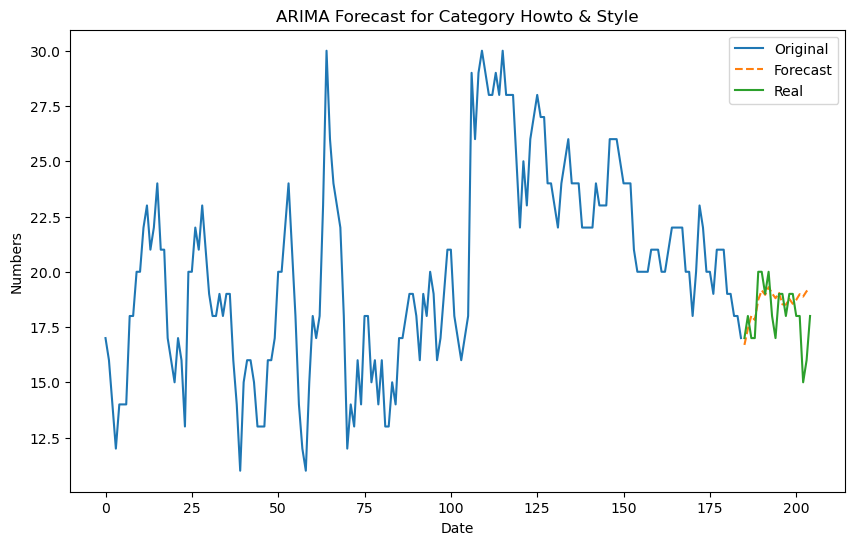

In [20]:
from matplotlib.ticker import MaxNLocator
category_data = time_series_10[:-20]
    

    
ts = category_data['counts']
original_ts = time_series_10['counts'][-20:]
model = ARIMA(ts, order=(15, 1, 3))
model_fit = model.fit()
    
forecast = model_fit.forecast(steps=20)
    
    
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.plot(original_ts, label='Real')
plt.title(f'ARIMA Forecast for Category {category_dict[id]}')
plt.xlabel('Date')
plt.ylabel('Numbers')
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))

plt.legend()
plt.show()